<a href="https://colab.research.google.com/github/Unoaccaso/lab_projects/blob/master/grid_bpm_n_slits_latex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulazioni numeriche per fenomeni d'interferenza

In [0]:
# ===================================
# Importing useful libraries
# ===================================

# we choose numpy to handle matrices and vectors
import numpy as np 
# library optimized for programs running on a GPU
try:
  import cupy as cp
except ModuleNotFoundError:
  !pip install cupy-cuda101
  import cupy as cp
#import numpy as cp
from time import time

import matplotlib.pyplot as plt
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

Intervallo delle x:[(array(-0.04), array(0.03999876))]


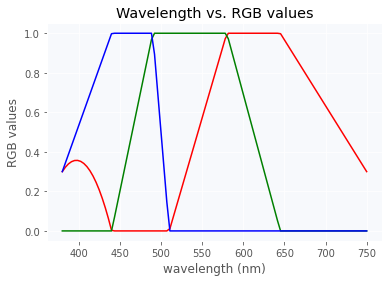

In [2]:
# ==================== 
# Physical Parameters  
# ====================
Ip = 4**2                 # intensity peak              
Ib = 1.0                  # background illumination                       
Lambda = 0.65e-6          # wavelength, [lambda] = m
k0 = 2*np.pi/Lambda       # vacuum wavevector, [k0] = m^(-1)                 
n0 = 1.                   # background index of refraction      
Lz = 0.12                 # computational length of sample, [Lz] = m     
Lx = 80e-3                # computational width of sample, [Lx] = m          

w0 = 0.25e-3              # beam width of gaussian beam parameter

h = 0.67e-3               # slit separation, [h] = m
inputposition=+h/2        # input position 

# =========================
# Computational Parameters 
# =========================
nstepx = 2024*32          # number of transverse grid points
nstepz = 1024             # number of longitudinal propagation steps

deltax = Lx/nstepx        # resolution in the x direction, [deltax] = m
deltaz = Lz/nstepz        # resolution in the z direction, IMPORTANT, [deltaz] = m
deltaf = 1/Lx             # spatial frequency step, [deltaf] = m^(-1)

# ===================
# Meshgrid generation
# ===================
z = cp.arange(0, Lz+deltaz, deltaz)                
x = -Lx/2 + (cp.arange(0, nstepx, 1))*deltax
print(f'Intervallo delle x:[{x.min(), x.max()}]')
# =====================
# Dispersive Step Setup
# =====================
# this is to get rid of fft shifts and the sort

ntx = 0     
kx = cp.zeros(nstepx)                              
for nn in range(nstepx):
    ikx = nn - ntx
    kx[nn]=2*np.pi*deltaf*ikx
    if nn + 1 - nstepx/2 == 0:
      ntx = nstepx
      
# =======================
# Input fields definition  
# =======================
def Gaussian(x, Ip = Ip, w0=w0):
  return cp.sqrt(Ip)*cp.exp(-(x**2)/(w0**2))

# ================
# Propagation loop
# ================
def propagate(Field, k = k0, nstepz=nstepz, deltaz=deltaz, keep_memory=False):
  # Fast fourier transform api
  fft, ifft = cp.fft.fft, cp.fft.ifft # faster with big matrices
  if keep_memory:
    FieldModuleMemory = cp.zeros(shape=(nstepx, nstepz+1))
    FieldModuleMemory[:, 0] = cp.abs(Field)
  else:
    FieldModuleMemory = None
  ArgumentOfPropagator  = ((k*n0)**(-1)*(kx**2))*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  tstart = time()
  for hh in range(nstepz):
      
      FieldTransform = fft(Field)*Propagator
      Field = ifft(FieldTransform)

      if keep_memory:
        FieldModuleMemory[:, 1+hh] = cp.abs(Field)

  print(f'elapsed time:{time()-tstart}')
  return Field, FieldModuleMemory

# =================
# Plotting function
# =================
def plot(Power, figsize=(15, 15), width=40, unit="mm"):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

# =============================
# To convert wavelength to cmap
#==============================
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning an approximated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength) #must be expressed in nm
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

wavelengths = np.linspace(380, 750, 100) # in nanometers
rgbs = np.stack([cp.asnumpy(wavelength_to_rgb(wl)) for wl in wavelengths])
plt.plot(wavelengths, rgbs[:, 0], "r-")
plt.plot(wavelengths, rgbs[:, 1], "g-")
plt.plot(wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.show()

cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment
#Lambda*1e9 is expressed in nm

# ======================
# To plot final spectrum
# ======================
def propagate_and_get_rgb(InputField, wavelength):
  k = 2*np.pi/(wavelength) #here k is expressed in 10^9 m^(-1)
  OutputField, FieldModuleMemory = propagate(InputField, k, keep_memory=True)
  P = cp.abs(OutputField)**2
  if P.ndim == 1:
    P = cp.stack((cp.abs(OutputField)**2,)*100, axis=0)
  rgb = cp.stack((P,)*3, axis=-1)/cp.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9), OutputField, FieldModuleMemory #wavelenght*1e9 is expressed in nm

# ====================
# Show result function
# ====================
def show_results(OutputPower, FieldModuleMemory, Color):
  fig = plt.figure(constrained_layout=True, figsize=(20, 20))
  gs = fig.add_gridspec(3, 3)

  ax1 = fig.add_subplot(gs[0, :2])
  ax1.set_title('Output power spectrum')
  ax1.plot(cp.asnumpy(x), cp.asnumpy(OutputPower))

  ax2 = fig.add_subplot(gs[1, :2])
  ax2.set_title('Diffracted light')
  ax2.imshow(cp.asnumpy(Color), extent=[x.min(), x.max(), 0, 1], aspect='auto')
  ax2.grid(False)

  ax3 = fig.add_subplot(gs[:2, 2])
  ax3.set_title('Diffracted light')
  ax3.imshow(cp.asnumpy((FieldModuleMemory.T)), origin='lower', 
             extent=[-0.02, 0.02, z.min(), z.max()], aspect = 'auto', 
             cmap='hot')
  ax3.grid(False)
  plt.show()
  plt.close()

#**Fascio monocromatico**

Fraunhofer distance: >>0.05733


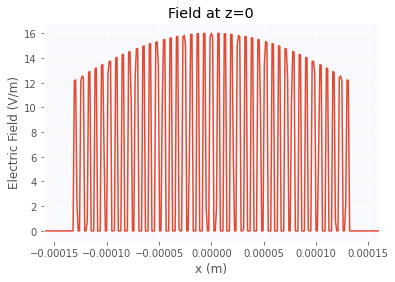

In [3]:
plt.close()
# =================
# Creating z=0 mask
# =================
InputField = 0*x          # Initializing field
dist = 0.65e-5               # distance betwen slices, [dist] = m
width = 0.15e-5              # width of slices, [width] = m
N = 20                       # slice number
lambdabis = 0.65e-6       # [lambdabis] = m

'''initializing field in z=0'''
InputField += np.sqrt(Ip)*(np.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  InputField += np.sqrt(Ip)*(np.exp(-(x-n*dist)**20/(width**20))+np.exp(-(x+n*dist)**20/(width**20)))
InputField *= Gaussian(x, w0=w0)
InputPower = cp.abs(InputField)**2
# visualizing the field in z=0
plt.plot(cp.asnumpy(x), cp.asnumpy(InputField))
plt.title('Field at z=0')
plt.xlabel('x (m)')
plt.ylabel('Electric Field (V/m)')
plt.xlim((-N*(dist+width), N*(dist+width)))
print(f'Fraunhofer distance: >>{(2*(N+1)*(dist))**2/2/lambdabis:.5f}')

In [4]:
# =====================
# Monochromatic light propagation
# =====================

wave, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, lambdabis)
OutputPower = cp.abs(OutputField)**2

elapsed time:2.112544059753418


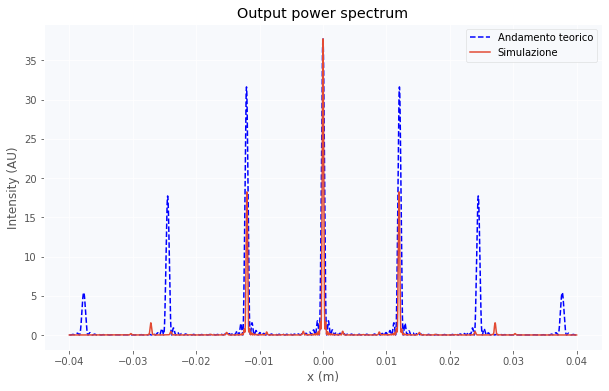

In [5]:
plt.close()
plt.figure(figsize=(10, 6))
#N = 2
sintheta = x/cp.sqrt(x**2+Lz**2)
beta = cp.pi*width/Lambda*sintheta
gamma = cp.pi*dist/Lambda*sintheta 

intense = 37.8*((cp.sin(beta)/beta)**2)*((cp.sin(N*gamma)/N/cp.sin(gamma))**2)

#intense = 29.*(np.sin(0.5*k0*width*sintheta)/(0.5*k0*width*sintheta))*2(np.sin(float(N)*0.5*k0*dist*sintheta)/(float(N)*np.sin(0.5*k0*dist*sintheta)))**2
plt.plot(cp.asnumpy(x), cp.asnumpy(intense), 'b--', label='Andamento teorico')
plt.plot(cp.asnumpy(x), cp.asnumpy(OutputPower), label='Simulazione')
plt.xlabel('x (m)')
plt.ylabel('Intensity (AU)')
plt.title('Output power spectrum')
plt.legend()
plt.show()


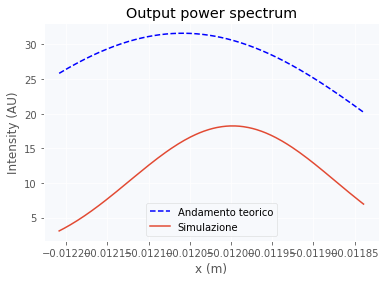

(64768,)


In [6]:
# max di sinistra
plt.plot(cp.asnumpy(x[22500:22800]), cp.asnumpy(intense[22500:22800]), 'b--', label='Andamento teorico')
plt.plot(cp.asnumpy(x[22500:22800]), cp.asnumpy(OutputPower[22500:22800]), label='Simulazione')
plt.xlabel('x (m)')
plt.ylabel('Intensity (AU)')
plt.title('Output power spectrum')
plt.legend()
plt.show()
print(x.shape)

In [7]:
print(intense[22500:22800].max())
print(OutputPower[22500:22800].max())
print(intense[22622])
print(x[22623])
print(OutputPower[22671])
print(x[22671])

31.62529713139447
18.240898901426792
31.625059252624986
-0.01205657114624506
18.240898901426792
-0.011997282608695651


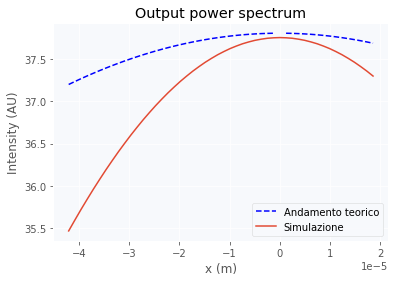

(64768,)


In [8]:
# max centrale
plt.plot(cp.asnumpy(x[32350:32400]), cp.asnumpy(intense[32350:32400]), 'b--', label='Andamento teorico')
plt.plot(cp.asnumpy(x[32350:32400]), cp.asnumpy(OutputPower[32350:32400]), label='Simulazione')
plt.xlabel('x (m)')
plt.ylabel('Intensity (AU)')
plt.title('Output power spectrum')
plt.legend()
plt.show()
print(x.shape)

In [9]:
print(intense[32350:32400].max())
print(OutputPower[32350:32400].max())
print(intense[32384])
print(x[32384])
print(OutputPower[32384])
print(x[32384])

nan
37.748343621796415
nan
0.0
37.748343621796415
0.0


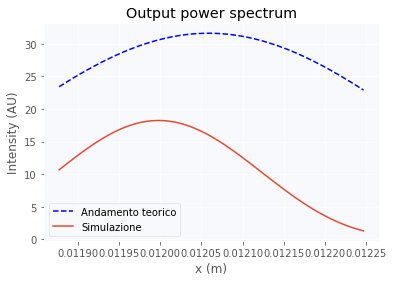

(64768,)


In [10]:
# max di destra
plt.plot(cp.asnumpy(x[42000:42300]), cp.asnumpy(intense[42000:42300]), 'b--', label='Andamento teorico')
plt.plot(cp.asnumpy(x[42000:42300]), cp.asnumpy(OutputPower[42000:42300]), label='Simulazione')
plt.xlabel('x (m)')
plt.ylabel('Intensity (AU)')
plt.title('Output power spectrum')
plt.legend()
plt.show()
print(x.shape)

In [11]:
print(intense[42000:42300].max())
print(OutputPower[42000:42300].max())
print(intense[42147])
print(x[42147])
print(OutputPower[42097])
print(x[42097])

31.62529713139447
18.240898901420177
31.62529713139447
0.012059041501976286
18.240898901420177
0.011997282608695654


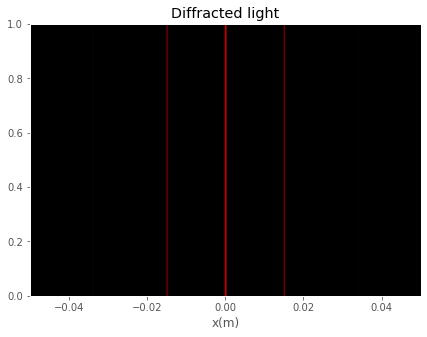

In [12]:
plt.close()
plt.figure(figsize=(7, 5))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy(wave), extent=[x.min()-0.01, x.max()+0.01, 0, 1], aspect='auto')
plt.xlabel('x(m)')
plt.grid(False)
plt.show()

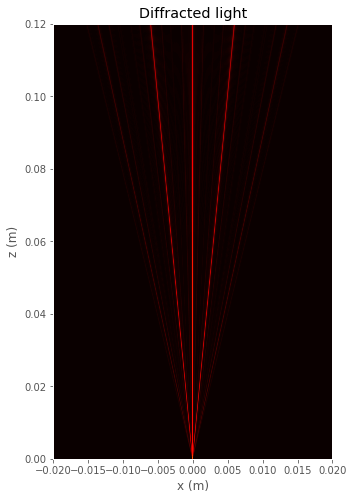

In [13]:
plt.close()
plt.figure(figsize=(5, 8))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy((FieldModuleMemory.T)), origin='lower', 
             extent=[-0.02, 0.02, z.min(), z.max()], aspect = 'auto', 
             cmap='hot')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.grid(False)
plt.show()

#**Spettri di potenza per diverse lunghezze d'onda**

Blue, Fraunhofer distance: >>0.07929
Green, Fraunhofer distance: >>0.06901
Red, Fraunhofer distance: >>0.05733


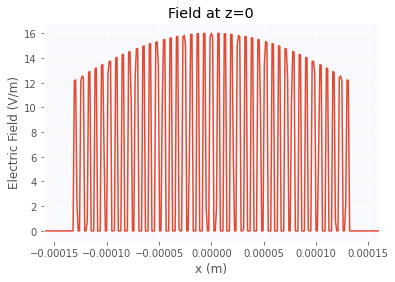

In [14]:
plt.close()
# =================
# Creating z=0 mask
# =================
InputField = 0*x          # Initializing field
dist = 0.65e-5               # distance between slices, [dist] = m
width = 0.15e-5              # width of slices, [width] = m
N = 20                       # slice number
Lz = 0.12
BlueLambda = 0.47e-6      # [BlueLambda] = m
GreenLambda = 0.54e-6     # [GreenLambda] = m
RedLambda = 0.65e-6       # [RedLambda] = m

'''initializing field in z=0'''
InputField += np.sqrt(Ip)*(np.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  InputField += np.sqrt(Ip)*(np.exp(-(x-n*dist)**20/(width**20))+np.exp(-(x+n*dist)**20/(width**20)))
InputField *= Gaussian(x, w0=w0)
InputPower = cp.abs(InputField)**2
# visualizing the field in z=0
plt.plot(cp.asnumpy(x), cp.asnumpy(InputField))
plt.title('Field at z=0')
plt.xlabel('x (m)')
plt.ylabel('Electric Field (V/m)')
plt.xlim((-N*(dist+width), N*(dist+width)))
print(f'Blue, Fraunhofer distance: >>{(2*(N+1)*(dist))**2/2/BlueLambda:.5f}')
print(f'Green, Fraunhofer distance: >>{(2*(N+1)*(dist))**2/2/GreenLambda:.5f}')
print(f'Red, Fraunhofer distance: >>{(2*(N+1)*(dist))**2/2/RedLambda:.5f}')

In [15]:
# =====================
# Monochromatic light propagation
# =====================

Blue, BlueOutputField, BlueFieldModuleMemory = propagate_and_get_rgb(InputField, BlueLambda)
BlueOutputPower = cp.abs(BlueOutputField)**2

Green, GreenOutputField, GreenFieldModuleMemory = propagate_and_get_rgb(InputField, GreenLambda)
GreenOutputPower = cp.abs(GreenOutputField)**2

Red, RedOutputField, RedFieldModuleMemory = propagate_and_get_rgb(InputField, RedLambda)
RedOutputPower = cp.abs(RedOutputField)**2

elapsed time:0.5017890930175781
elapsed time:0.5066521167755127
elapsed time:0.49636006355285645


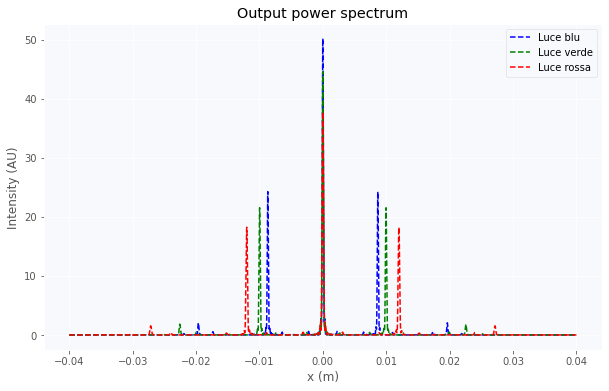

In [16]:
plt.close()
plt.figure(figsize=(10, 6))
#N = 2
#sintheta = x/cp.sqrt(x**2+Lz**2)
#beta = cp.pi*width/Lambda*sintheta
#gamma = cp.pi*dist/Lambda*sintheta 

#intense = 0.17*((cp.sin(beta)/beta)**2)*((cp.sin(N*gamma)/N/cp.sin(gamma))**2)

#intense = 29.*(np.sin(0.5*k0*width*sintheta)/(0.5*k0*width*sintheta))*2(np.sin(float(N)*0.5*k0*dist*sintheta)/(float(N)*np.sin(0.5*k0*dist*sintheta)))**2
plt.plot(cp.asnumpy(x), cp.asnumpy(BlueOutputPower),'b--', label='Luce blu')
plt.plot(cp.asnumpy(x), cp.asnumpy(GreenOutputPower), 'g--', label='Luce verde')
plt.plot(cp.asnumpy(x), cp.asnumpy(RedOutputPower), 'r--', label='Luce rossa')
plt.xlabel('x (m)')
plt.ylabel('Intensity (AU)')
plt.title('Output power spectrum')
plt.legend()
plt.show()


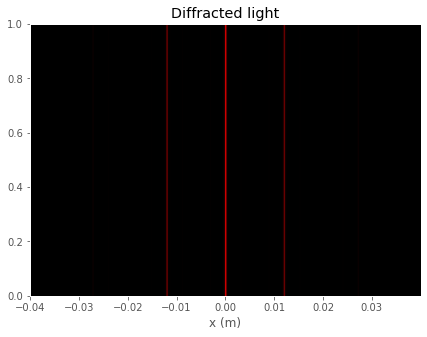

In [17]:
plt.close()
plt.figure(figsize=(7, 5))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy(Red), extent=[x.min(), x.max(), 0, 1], aspect='auto')
plt.xlabel('x (m)')
plt.grid(False)
plt.show()

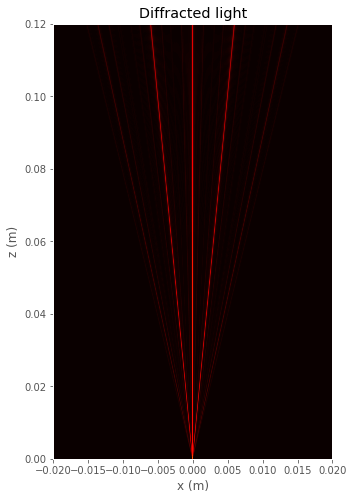

In [18]:
plt.close()
plt.figure(figsize=(5, 8))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy((FieldModuleMemory.T)), origin='lower', 
             extent=[-0.02, 0.02, z.min(), z.max()], aspect = 'auto', 
             cmap='hot')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.grid(False)
plt.show()

#**Infrarosso**

Fraunhofer distance: >>0.00004


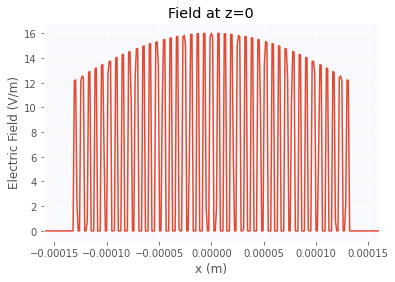

In [19]:
plt.close()
# =================
# Creating z=0 mask
# =================
InputField = 0*x          # Initializing field
dist = 0.65e-5               # distance betwen slices, [dist] = m
width = 0.15e-5              # width of slices, [width] = m
N = 20                       # slice number
lambdabis = 0.85e-3       # [lambdabis] = m

'''initializing field in z=0'''
InputField += np.sqrt(Ip)*(np.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  InputField += np.sqrt(Ip)*(np.exp(-(x-n*dist)**20/(width**20))+np.exp(-(x+n*dist)**20/(width**20)))
InputField *= Gaussian(x, w0=w0)
InputPower = cp.abs(InputField)**2
# visualizing the field in z=0
plt.plot(cp.asnumpy(x), cp.asnumpy(InputField))
plt.title('Field at z=0')
plt.xlabel('x (m)')
plt.ylabel('Electric Field (V/m)')
plt.xlim((-N*(dist+width), N*(dist+width)))
print(f'Fraunhofer distance: >>{(2*N*(dist))**2/2/lambdabis:.5f}')

In [20]:
# =====================
# Monochromatic light propagation
# =====================

wave, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, lambdabis)
OutputPower = cp.abs(OutputField)**2

elapsed time:0.5402576923370361


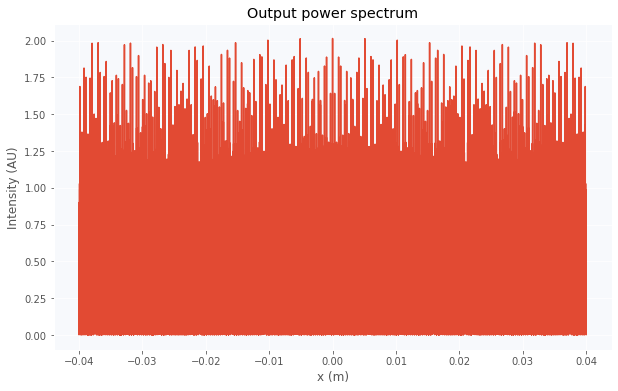

In [21]:
plt.close()
plt.figure(figsize=(10, 6))
#N = 2
#sintheta = x/cp.sqrt(x**2+Lz**2)
#beta = cp.pi*width/Lambda*sintheta
#gamma = cp.pi*dist/Lambda*sintheta 

#intense = 15.8*((cp.sin(beta)/beta)**2)*((cp.sin(N*gamma)/N/cp.sin(gamma))**2)

#intense = 29.*(np.sin(0.5*k0*width*sintheta)/(0.5*k0*width*sintheta))*2(np.sin(float(N)*0.5*k0*dist*sintheta)/(float(N)*np.sin(0.5*k0*dist*sintheta)))**2
#plt.plot(cp.asnumpy(x), cp.asnumpy(intense), 'b--')
plt.plot(cp.asnumpy(x), cp.asnumpy(OutputPower))
plt.xlabel('x (m)')
plt.ylabel('Intensity (AU)')
plt.title('Output power spectrum')
plt.show()


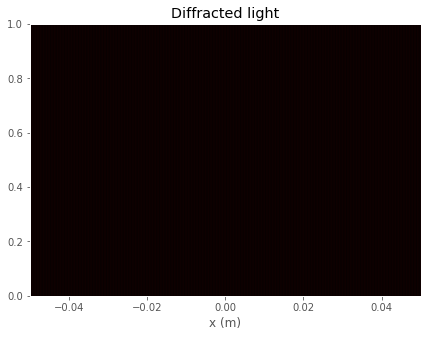

In [22]:
plt.close()
plt.figure(figsize=(7, 5))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy(wave), extent=[x.min()-0.01, x.max()+0.01, 0, 1], aspect='auto')
plt.xlabel('x (m)')
plt.grid(False)
plt.show()

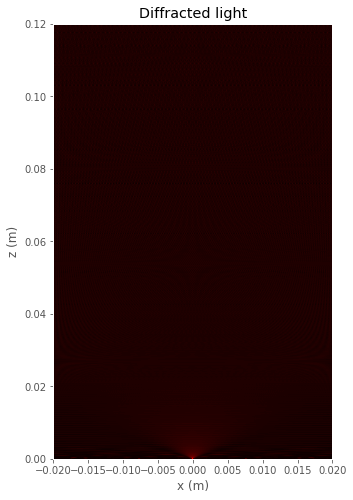

In [23]:
plt.close()
plt.figure(figsize=(5, 8))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy((FieldModuleMemory.T)), origin='lower', 
             extent=[-0.02, 0.02, z.min(), z.max()], aspect = 'auto', 
             cmap='hot')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.grid(False)
plt.show()

#**Luce bianca**

fraunhofer distance: >>0.079


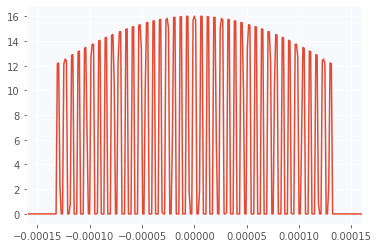

In [24]:
# =================
# Creating z=0 mask
# =================
InputField = 0*x          # Initializing field
dist = 0.65e-5               # distance betwen slices, [dist] = m
width = 0.15e-5              # width of slices, [width] = m
N = 20                       # slice number

'''initializing field in z=0'''
InputField += np.sqrt(Ip)*(np.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  InputField += np.sqrt(Ip)*(np.exp(-(x-n*dist)**20/(width**20))+np.exp(-(x+n*dist)**20/(width**20)))
InputField *= Gaussian(x, w0=w0)
InputPower = cp.abs(InputField)**2
# visualizing the field in z=0
plt.plot(cp.asnumpy(x), cp.asnumpy(InputField))
plt.xlim((-N*(dist+width), N*(dist+width)))
print(f'fraunhofer distance: >>{(N*(dist+width)*2)**2/2/Lambda:.3f}')

In [25]:
# =======================
# White light propagation
# =======================
''' making color array '''
wavelengths = cp.linspace(400, 750, 40)*1e-9 #here the wavelenghts are expressed in m
Color, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, 500*1e-9)
for wavelength in wavelengths:
  Color_t, OutputField_t, FieldModuleMemory_t = propagate_and_get_rgb(InputField, wavelength)
  Color += Color_t
  OutputField += OutputField_t
  FieldModuleMemory += FieldModuleMemory_t
OutputPower = cp.abs(OutputField)**2

elapsed time:0.5316424369812012
elapsed time:0.5094385147094727
elapsed time:0.5180747509002686
elapsed time:0.5025203227996826
elapsed time:0.5083458423614502
elapsed time:0.4848299026489258
elapsed time:0.5065968036651611
elapsed time:0.4938356876373291
elapsed time:0.50490403175354
elapsed time:0.5024755001068115
elapsed time:0.5174036026000977
elapsed time:0.5012083053588867
elapsed time:0.5255417823791504
elapsed time:0.49982428550720215
elapsed time:0.5187959671020508
elapsed time:0.49762988090515137
elapsed time:0.5133733749389648
elapsed time:0.4985489845275879
elapsed time:0.5231022834777832
elapsed time:0.4979419708251953
elapsed time:0.5208268165588379
elapsed time:0.5099899768829346
elapsed time:0.5050351619720459
elapsed time:0.4956851005554199
elapsed time:0.500873327255249
elapsed time:0.49726343154907227
elapsed time:0.5082521438598633
elapsed time:0.5098886489868164
elapsed time:0.4974527359008789
elapsed time:0.49601054191589355
elapsed time:0.5013716220855713
elapsed

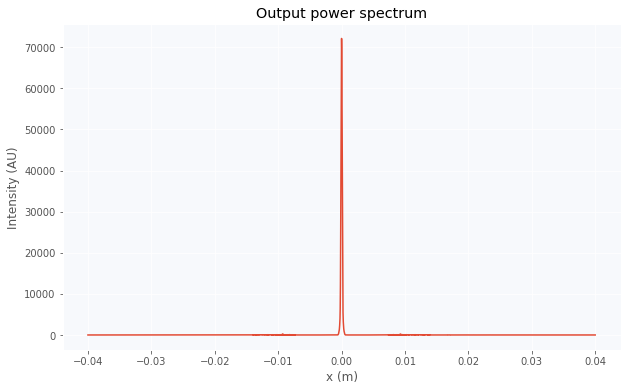

In [26]:
plt.close()
plt.figure(figsize=(10, 6))
#N = 2
#sintheta = x/cp.sqrt(x**2+Lz**2)
#beta = cp.pi*width/Lambda*sintheta
#gamma = cp.pi*dist/Lambda*sintheta 

#intense = 15.8*((cp.sin(beta)/beta)**2)*((cp.sin(N*gamma)/N/cp.sin(gamma))**2)

#intense = 29.*(np.sin(0.5*k0*width*sintheta)/(0.5*k0*width*sintheta))*2(np.sin(float(N)*0.5*k0*dist*sintheta)/(float(N)*np.sin(0.5*k0*dist*sintheta)))**2
#plt.plot(cp.asnumpy(x), cp.asnumpy(intense), 'b--')
plt.plot(cp.asnumpy(x), cp.asnumpy(OutputPower))
plt.xlabel('x (m)')
plt.ylabel('Intensity (AU)')
plt.title('Output power spectrum')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


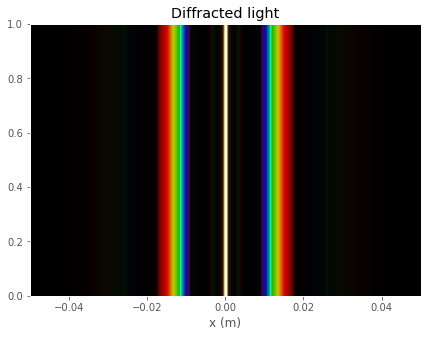

In [27]:
plt.close()
plt.figure(figsize=(7, 5))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy(Color), extent=[x.min()-0.01, x.max()+0.01, 0, 1], aspect='auto')
plt.xlabel('x (m)')
plt.grid(False)
plt.show()

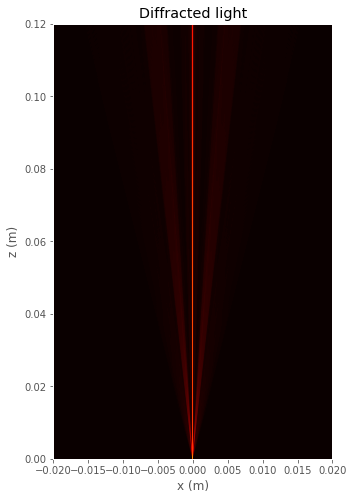

In [28]:
plt.close()
plt.figure(figsize=(5, 8))
plt.title('Diffracted light')
plt.imshow(cp.asnumpy((FieldModuleMemory.T)), origin='lower', 
             extent=[-0.02, 0.02, z.min(), z.max()], aspect = 'auto', 
             cmap='hot')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.grid(False)
plt.show()